In [94]:
from langchain_groq import ChatGroq
from CONFIG import GROQ_MODEL, OPENAI_EMBEDDED_MODEL
from langchain_openai import OpenAIEmbeddings
from pydantic import BaseModel, StrictBool
from typing import List, TypedDict
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from dotenv import load_dotenv
from langchain_community.vectorstores import FAISS
from langgraph.graph import START, END, StateGraph
from langchain_core.prompts import ChatPromptTemplate

In [95]:
load_dotenv()
llm = ChatGroq(model=GROQ_MODEL)
embedded_model = OpenAIEmbeddings(model=OPENAI_EMBEDDED_MODEL)

In [97]:
pdf = PyPDFLoader(file_path="A:\AI_Projects_Practice\Self-RAG\Mohamed-Hammad-UCV.pdf").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=20).split_documents(pdf)
vector_store = FAISS.from_documents(splitter, embedded_model)

In [98]:
# retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 2})

In [99]:
class state(TypedDict):
    query: str
    yes_or_not: bool

In [115]:
class should_retrive_or_not(BaseModel):
    yes_or_no: StrictBool

def decision_node(state: state):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                  "system",
                  "You are a strict decision maker. You MUST set yes_or_no as a boolean true or false (not string).\n"
                  "yes_or_no=true when the query needs document retrieval — personal info (CV, resume, experience) OR recent/updated/latest information\n"
			"yes_or_no=false ONLY when the query is about general/static knowledge that LLM already knows (science, math, history, etc.)\n"
		),
		(
			"human",
			"user query is: {query}"
		)
	  ]
    )

    output = prompt | llm.with_structured_output(should_retrive_or_not)
    yes_no  = output.invoke({"query" : state['query']})
    return {
        'yes_or_not': yes_no.yes_or_no
    }

In [116]:
def retriever_node(state: state):
    print('document retrieved...')

def parametric(state: state):
    print('output get from my parametric knowledge...')

In [117]:
def router_node(state: state):
    if state['yes_or_not']:
        return 'retriever_node'
    
    return 'parametric'

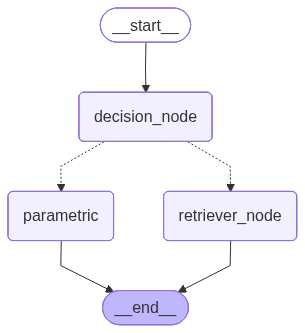

In [118]:
graph = StateGraph(state)

graph.add_node('decision_node', decision_node)
graph.add_node('retriever_node', retriever_node)
graph.add_node('parametric', parametric)

graph.add_edge(START, 'decision_node')
graph.add_conditional_edges(
    'decision_node',
    router_node,
    {
        'retriever_node': 'retriever_node',
        'parametric': 'parametric'
    }
)

graph.add_edge("retriever_node", END)
graph.add_edge("parametric", END)

gra = graph.compile()
gra

In [119]:
gra.invoke({'query': 'transformer in DEEPLEARNING'})

output get from my parametric knowledge...


{'query': 'transformer in DEEPLEARNING', 'yes_or_not': False}

In [120]:
gra.invoke({'query': 'leave schedule of my office'})

document retrieved...


{'query': 'leave schedule of my office', 'yes_or_not': True}

In [121]:
gra.invoke({'query': 'updated news? related to AI'})

document retrieved...


{'query': 'updated news? related to AI', 'yes_or_not': True}